In [1]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/functions"))

In [2]:
from load_poses import get_poses_from_file
dataset_path = "/workspace/data/pose-prediction-odometry/tmp-testing/"
RO_se3s,RO_timestamps = get_poses_from_file(dataset_path)

Loading poses from monolithic file...
reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/tmp-testing/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 8421 poses.


In [3]:
# Crop poses - there was a dud pose at 6342, this is a quick fix for now
max_poses = 6000
RO_se3s = RO_se3s[:max_poses]
RO_timestamps = RO_timestamps[:max_poses]

train_test_ratio = 0.8
split_idx = int(len(RO_timestamps)*train_test_ratio)
train_RO_se3s = RO_se3s[:split_idx]
train_RO_timestamps = RO_timestamps[:split_idx]
test_RO_se3s = RO_se3s[split_idx:]
test_RO_timestamps = RO_timestamps[split_idx:]
print("Train set size:",len(train_RO_timestamps))
print("Test set size:",len(test_RO_timestamps))

Train set size: 4800
Test set size: 1200


In [4]:
t_x_data = np.zeros(len(train_RO_timestamps))
t_y_data = np.zeros(len(train_RO_timestamps))
t_theta_data = np.zeros(len(train_RO_timestamps))

for i in range(len(train_RO_timestamps)):
    t_x_data[i] = train_RO_se3s[i][0,3]
    t_y_data[i] = train_RO_se3s[i][1,3]
    t_theta_data[i] = np.arccos(train_RO_se3s[i][0,0])
    
test_t_x_data = np.zeros(len(test_RO_timestamps))

for i in range(len(test_RO_timestamps)):
    test_t_x_data[i] = test_RO_se3s[i][0,3]

In [5]:
num_features = 1
num_frames = 2
input_size = num_features * num_frames
output_size = num_features

In [6]:
dim1_data = t_x_data
dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()


def prepare_data(dim1_data_scaled,train_validate_ratio,num_features,num_frames,input_size,output_size):
    """
    Data preparation - mock of the real function (just for x here, no y and theta)
    
    For the two frame case, input tensor holds x, y, and theta data in frame 1, frame 2
    [x1,y1,th1,x2,y2,th2]
    These are offset, so that x1 goes up until the second last frame
    (current frame is treated as future prediction)

    Output tensor holds single frame, for x, y, and theta values
    This is cropped to exclude the first n frames (n=2 here) and run up until the end
    So a synthesised 'future' value to aim for

    """
    import torch
    from torch.utils.data.dataset import TensorDataset

    t_x = torch.tensor(dim1_data_scaled)

    x_data = torch.zeros(len(dim1_data_scaled)-num_frames,input_size)
    start_idx = 0
    end_idx = len(x_data)
    frame_idx = num_frames - 1

    for i in range(num_frames):
        x_data[:,frame_idx*num_features] = t_x[start_idx:end_idx]
        start_idx+=1
        end_idx+=1
        frame_idx-=1 # older frames are assigned to later columns

    y_data = torch.zeros(len(dim1_data_scaled)-num_frames,output_size)
    y_data[:,0] = t_x[num_frames:]
    
    x_rows = x_data.size()[0]
    training_idx_limit = int(train_validate_ratio * x_rows)

    x_train = x_data[:training_idx_limit,:]
    x_valid = x_data[training_idx_limit:,:]

    y_train = y_data[:training_idx_limit,:]
    y_valid = y_data[training_idx_limit:,:]

    print('x_data dimensions:',x_data.size())
    print('x_train dimensions:',x_train.size())
    print('x_valid dimensions:',x_valid.size())
    print('y_data dimensions:',y_data.size())
    print('y_train dimensions:',y_train.size())
    print('y_valid dimensions:',y_valid.size())
    
    train_ds = TensorDataset(x_train,y_train)
    valid_ds = TensorDataset(x_valid,y_valid)
    
    return train_ds, valid_ds

# from dataset_prep import prepare_data
train_validate_ratio = 0.8
train_ds,valid_ds = \
prepare_data(dim1_data_scaled, \
             train_validate_ratio,num_features,num_frames,input_size,output_size)

x_data dimensions: torch.Size([4798, 2])
x_train dimensions: torch.Size([3838, 2])
x_valid dimensions: torch.Size([960, 2])
y_data dimensions: torch.Size([4798, 1])
y_train dimensions: torch.Size([3838, 1])
y_valid dimensions: torch.Size([960, 1])


In [7]:
test_dim1_data = test_t_x_data
# We won't have access to mean and std of the test data, so must use the training set mean and std to do scaling
test_dim1_data_scaled = (test_dim1_data - dim1_data.mean())/dim1_data.std()

def prepare_test_data(test_dim1_data_scaled,num_features,num_frames,input_size,output_size):
    """
    Data preparation for test data

    """
    import torch
    from torch.utils.data.dataset import TensorDataset

    t_x = torch.tensor(test_dim1_data_scaled)

    x_test = torch.zeros(len(test_dim1_data_scaled)-num_frames,input_size)
    start_idx = 0
    end_idx = len(x_test)
    frame_idx = num_frames - 1

    for i in range(num_frames):
        x_test[:,frame_idx*num_features] = t_x[start_idx:end_idx]
        start_idx+=1
        end_idx+=1
        frame_idx-=1 # older frames are assigned to later columns

    y_test = torch.zeros(len(test_dim1_data_scaled)-num_frames,output_size)
    y_test[:,0] = t_x[num_frames:]

    print('x_test dimensions:',x_test.size())
    print('y_test dimensions:',y_test.size())
    
    test_ds = TensorDataset(x_test,y_test)
    
    return test_ds

test_ds = prepare_test_data(test_dim1_data_scaled, num_features,num_frames,input_size,output_size)

x_test dimensions: torch.Size([1198, 2])
y_test dimensions: torch.Size([1198, 1])


In [8]:
import torch.nn as nn
#our class must extend nn.Module
class BiggerNetwork(nn.Module):
    def __init__(self):
        super(BiggerNetwork,self).__init__()
        #Our network consists of 3 layers. 1 input, 1 hidden and 1 output layer
        #This applies Linear transformation to input data. 
        self.fc1 = nn.Linear(input_size,3)
        
        #This applies linear transformation to produce output data
        self.fc2 = nn.Linear(3,output_size)
        
    #This must be implemented
    def forward(self,x):
        #Output of the first layer
        x = self.fc1(x)
        #Activation function is Relu. Feel free to experiment with this
        x = torch.relu(x) # F.tanh(x)
        #This produces output
        x = self.fc2(x)
        return x    
    
class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(input_size,output_size)

    def forward(self, xb):
        return self.lin(xb)

In [14]:
import torch.nn as nn
import torch.optim as optim
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
    def forward(self, input, future=0, y=None):
        outputs = []
        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [21]:
from network_helpers import *

def loss_batch_tmp(model,loss_func,xb,yb,opt=None):    
    loss=loss_func(model(xb),yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(),len(xb)

def fit_tmp(epochs, model, loss_func, opt, train_dl, valid_dl):
    validation_loss = []
    train_loss = []
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            losses,nums = loss_batch_tmp(model, loss_func, xb, yb, opt)
            loss_in_training = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            train_loss.append(loss_in_training)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch_tmp(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        validation_loss.append(val_loss)
        print(epoch, val_loss)
    return train_loss,validation_loss

batch_size = 20
epochs = 10
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model = BiggerNetwork() #SimpleNetwork()
loss_func = nn.MSELoss() #nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train_loss,validation_loss = fit_tmp(epochs, model, loss_func, optimizer, train_dl, valid_dl)


0 0.015680294930158805
1 0.0065904117218451574
2 0.005297344375624864
3 0.005069708103595379
4 0.005127514450578019
5 0.00467357192489241
6 0.005957674283611898
7 0.004991177719299837
8 0.004885542819465627
9 0.004669244358410651


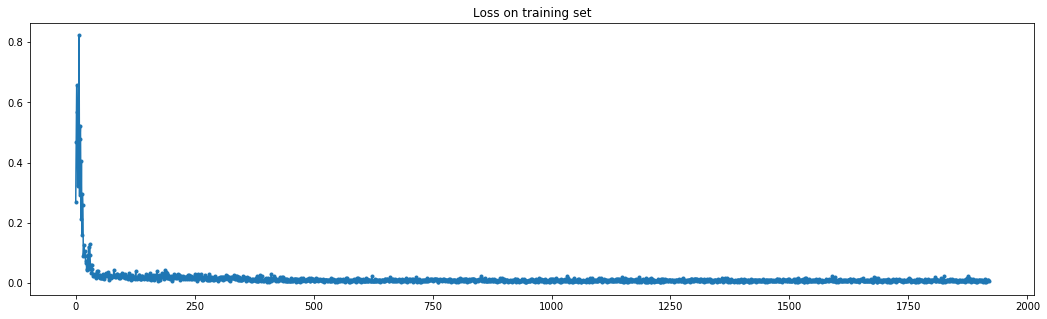

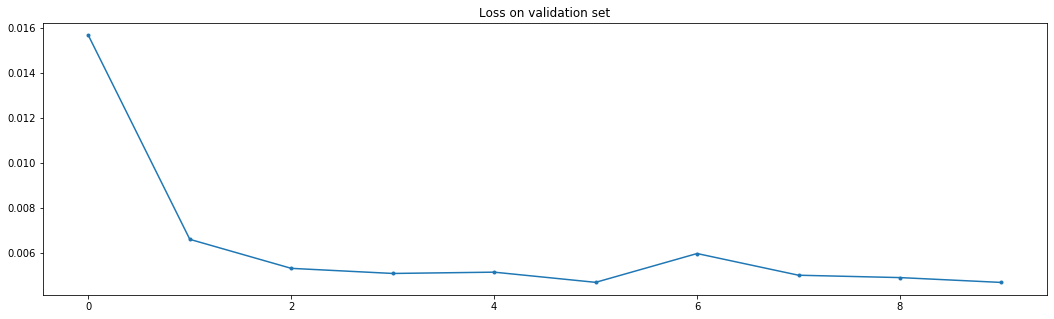

In [22]:
plt.figure(figsize=(18,5))
plt.title("Loss on training set")
plt.plot(train_loss,'.-')
plt.figure(figsize=(18,5))
plt.title("Loss on validation set")
plt.plot(validation_loss,'.-')

torch.Size([3838, 2]) torch.Size([3838, 1])


Text(0.5, 1.0, 'Pose in x direction for training set')

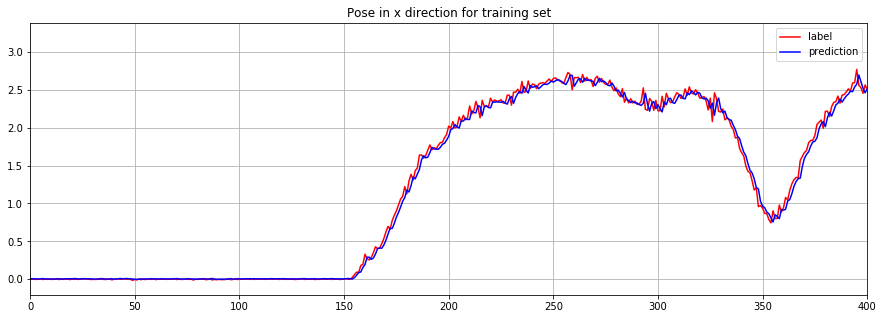

In [23]:
train_data_loader = DataLoader(dataset=train_ds,
                                     batch_size=len(train_ds),
                                     shuffle=False,
                                     num_workers=1)
    
batch_x, batch_y = next(iter(train_data_loader))
prediction = model(batch_x).data
print(batch_x.shape, batch_y.shape)

rescaled_gt = batch_y*dim1_data.std() + dim1_data.mean()
rescaled_prediction = prediction*dim1_data.std() + dim1_data.mean()

plt.figure(figsize=(15,5))
plt.plot(rescaled_gt,'r',label="label")
plt.plot(rescaled_prediction,'b',label="prediction")
plt.grid()
plt.legend()
plt.xlim(0,400)
plt.title("Pose in x direction for training set")

torch.Size([960, 2]) torch.Size([960, 1])


Text(0.5, 1.0, 'Pose in x direction for validation set')

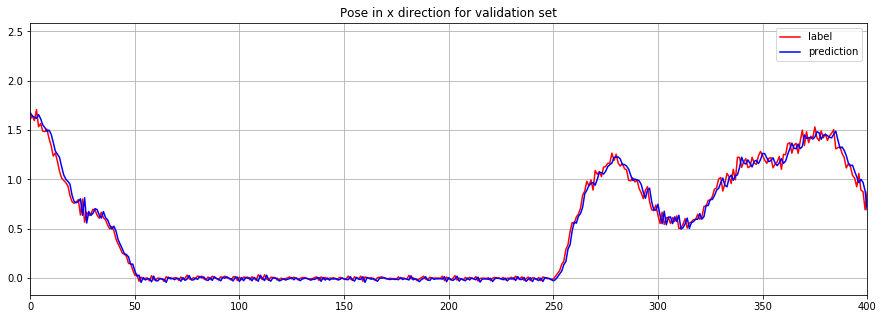

In [12]:
valid_data_loader = DataLoader(dataset=valid_ds,
                                     batch_size=len(valid_ds),
                                     shuffle=False,
                                     num_workers=1)
    
batch_x, batch_y = next(iter(valid_data_loader))
prediction = model(batch_x).data
print(batch_x.shape, batch_y.shape)

rescaled_gt = batch_y*dim1_data.std() + dim1_data.mean()
rescaled_prediction = prediction*dim1_data.std() + dim1_data.mean()

plt.figure(figsize=(15,5))
plt.plot(rescaled_gt,'r',label="label")
plt.plot(rescaled_prediction,'b',label="prediction")
plt.grid()
plt.legend()
plt.xlim(0,400)
plt.title("Pose in x direction for validation set")

torch.Size([1198, 2]) torch.Size([1198, 1])


Text(0.5, 1.0, 'Pose in x direction for test set')

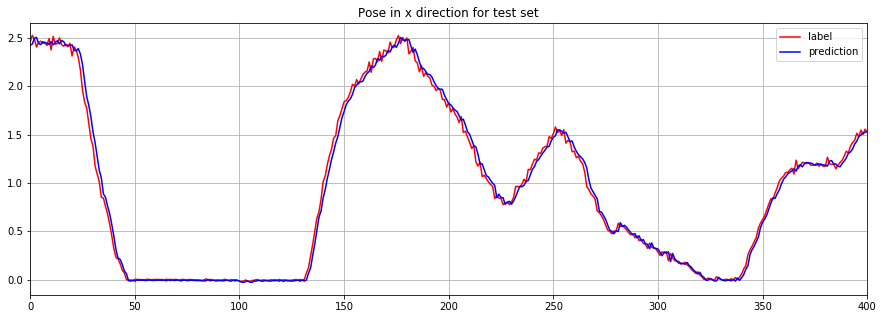

In [13]:
test_data_loader = DataLoader(dataset=test_ds,
                                     batch_size=len(test_ds),
                                     shuffle=False,
                                     num_workers=1)
    
batch_x, batch_y = next(iter(test_data_loader))
prediction = model(batch_x).data
print(batch_x.shape, batch_y.shape)

rescaled_gt = batch_y*dim1_data.std() + dim1_data.mean()
rescaled_prediction = prediction*dim1_data.std() + dim1_data.mean()

plt.figure(figsize=(15,5))
plt.plot(rescaled_gt,'r',label="label")
plt.plot(rescaled_prediction,'b',label="prediction")
plt.grid()
plt.legend()
plt.xlim(0,400)
plt.title("Pose in x direction for test set")

In [246]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

# sc = MinMaxScaler()
# training_data = sc.fit_transform(training_set)

training_data = dim1_data_scaled.reshape(-1,1)

seq_length = 3
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.05)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print("dataX:",dataX.shape)
print("trainX:",trainX.shape)
print("testX:",testX.shape)

dataX: torch.Size([4796, 3, 1])
trainX: torch.Size([239, 3, 1])
testX: torch.Size([4557, 3, 1])


In [255]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # hidden and cell states
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Debugging
#         print("x",x.shape,"\n",x)
#         print("h_0",h_0.shape,"\n",h_0)
#         print("c_0",c_0.shape,"\n",c_0)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [256]:
num_epochs = 500
learning_rate = 0.01

input_size = 1
hidden_size = 20
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
#     print("training x shape:",trainX.shape)
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 50 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 1.83399
Epoch: 50, loss: 0.01724
Epoch: 100, loss: 0.00670
Epoch: 150, loss: 0.00366
Epoch: 200, loss: 0.00244
Epoch: 250, loss: 0.00202
Epoch: 300, loss: 0.00194
Epoch: 350, loss: 0.00192
Epoch: 400, loss: 0.00191
Epoch: 450, loss: 0.00191


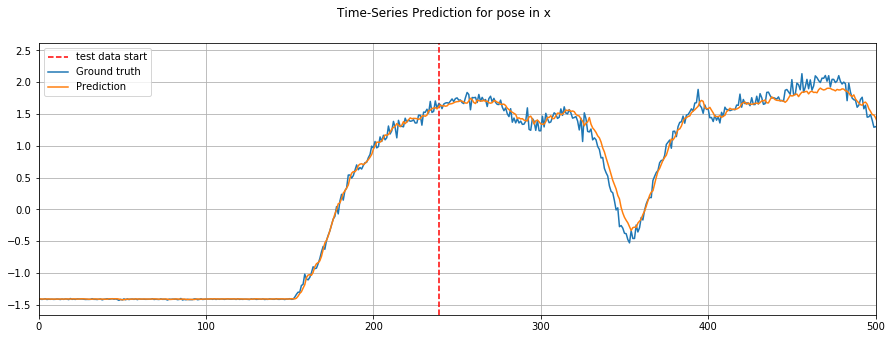

In [257]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(15,5))
plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
plt.xlim(0,500)
plt.plot(dataY_plot,label="Ground truth")
plt.plot(data_predict,label="Prediction")
plt.suptitle('Time-Series Prediction for pose in x')
plt.grid()
plt.legend()
plt.show()

In [175]:
seq_length = 3
batch = 1 # not sure what this is for, is it number of batches or batch size?
input_size = 5 # this is awfully vague...
hidden_size = 20 # layer size
num_layers = 2
rnn = nn.LSTM(input_size, hidden_size, num_layers)
input = torch.randn(seq_length, batch, input_size)
h0 = torch.randn(num_layers, batch, hidden_size)
c0 = torch.randn(num_layers, batch, hidden_size)
output, (hn, cn) = rnn(input, (h0, c0))

In [176]:
input

tensor([[[ 1.1771,  1.0122,  0.5495, -1.0577, -0.8148]],

        [[ 0.8687, -0.9709,  1.3410, -0.8295,  1.4131]],

        [[-0.1896,  0.0835,  1.5252, -0.8040, -1.2459]]])

In [177]:
h0.shape

torch.Size([2, 1, 20])